In [1]:
# importing libraries
import os
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from skimage import data, exposure
import numpy as np
import pywt
import pickle
import pywt.data
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
path = 'C:/Users/Gebruiker/Desktop/Year 4/AMLS-assignment'

In [3]:
print(path)

C:/Users/Gebruiker/Desktop/Year 4/AMLS-assignment


# Feature Selection Algorithms and Functions

In [3]:
# first feature selection technique is HOG
def calculate_hog_features(image):
    hog_image = cv2.resize(image, (256, 128), interpolation=cv2.INTER_AREA)
    fd, hog_image = hog(hog_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

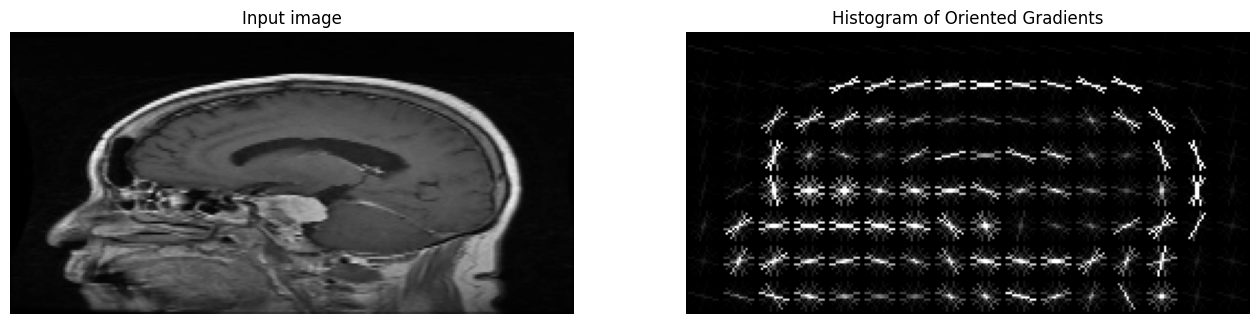

In [4]:
# showing example of what the hog features show

img = cv2.imread(os.path.join(path, 'dataset/image/IMAGE_0000.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fd, hog_image = calculate_hog_features(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

img = cv2.resize(img, (256, 128))

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [5]:
# second feature is wavelets with 'haar' feature

# adapting function so that I can apply the transform multiple times
def wavelet_feature(original, iterations):
    for i in range(iterations):
        coeffs = pywt.dwt2(original, 'haar')
        LL, (LH, HL, HH) = coeffs
        original = LL
    return coeffs

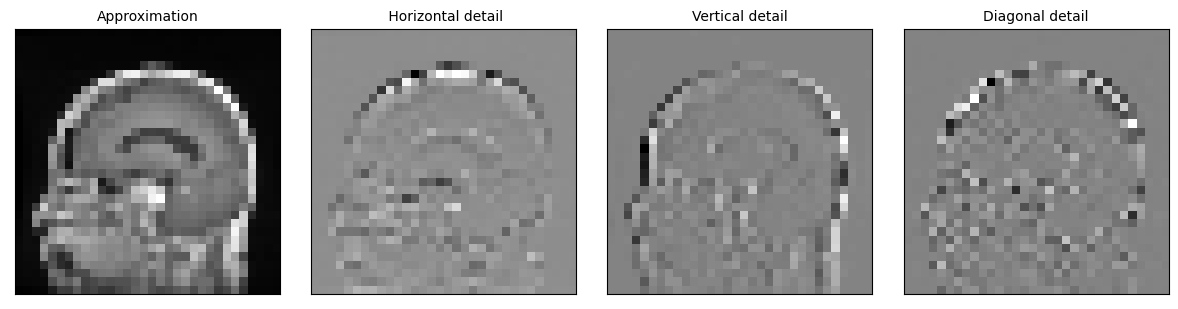

In [6]:
# Load image
original = cv2.imread(os.path.join(path, 'dataset/image/IMAGE_0000.jpg'))
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs = wavelet_feature(original, 4)
LL, (LH, HL, HH) = coeffs
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

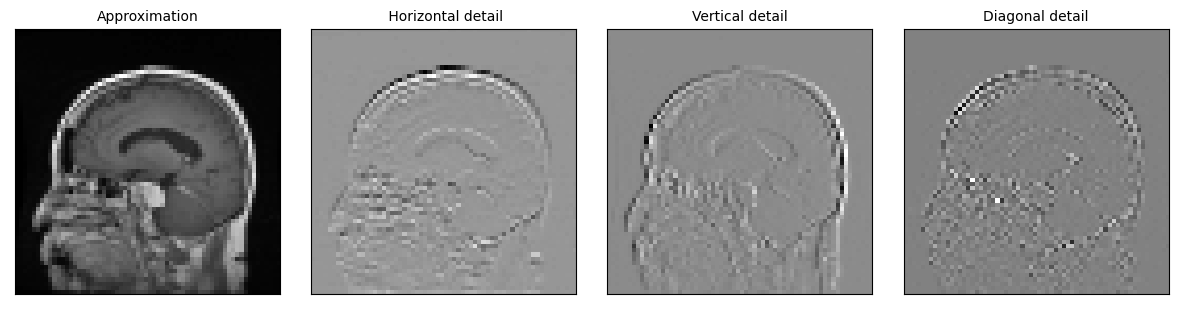

In [7]:
# Load image
original = cv2.imread(os.path.join(path, 'dataset/image/IMAGE_0000.jpg'))
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs = wavelet_feature(original, 3)
LL, (LH, HL, HH) = coeffs
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

# Data Augmentation

In [8]:
# saving features for comparisons
# creating directories for features to go in
import shutil

try:
    os.mkdir(os.path.join(path, 'Task B/features'))
except:
    print('Directory already created')
try:
    os.mkdir(os.path.join(path, 'Task B/features/train'))
except:
    print('Directory already created')
try:
    os.mkdir(os.path.join(path, 'Task B/features/train_aug'))
except:
    print('Directory already created')
try:
    os.mkdir(os.path.join(path, 'Task B/features/validate'))
except:
    print('Directory already created')
try:
    os.makedirs(path + '/Task B/features/test')
except:
    print('Directory exists')


Directory already created
Directory already created
Directory already created
Directory already created
Directory exists


In [9]:
# splitting test and train data
df = pd.read_csv(path + '/dataset/label.csv')

# using random state so that it is repeatable
df_train = df.sample(frac=0.7,random_state=0)
df_validate = df.drop(df_train.index)
df_test = pd.read_csv(path + '/dataset/test/label.csv')

In [10]:
import shutil
# data augmentation on training set
import imgaug.augmenters as iaa

shutil.rmtree(path + '/dataset/image_aug')
os.makedirs(path + '/dataset/image_aug')

# creating sequences for images
seq_flip = iaa.Sequential([
    iaa.Fliplr(1)
])
seq_rotate = iaa.Sequential([
    iaa.Affine(rotate=(90, -90))
])
images = []
labels = []
# saving all images and labels to arrays for use later
for row in tqdm(df_train.iterrows()):
    image_name = row[1][0]
    label = row[1][1]
    # if label == 'no_tumor':
    img = cv2.imread(os.path.join(path, f'dataset/image/{image_name}'))
    images.append(img)
    labels.append(label)

print(len(images))

# applying transforms to all images
rotated = seq_rotate(images=images)
flipped = seq_flip(images=images)

# creating new dataframe to store augmented images
df_aug = pd.DataFrame(columns=['file_name', 'label'])


for i in tqdm(range(len(images))):
    cv2.imwrite(path + '/dataset/image_aug/rotated_{:0>4}.jpg'.format(i), rotated[i])
    cv2.imwrite(path + '/dataset/image_aug/flipped_{:0>4}.jpg'.format(i), flipped[i])

    new1 = {'file_name': 'rotated_{:0>4}.jpg'.format(i), 'label': labels[i]}
    new2 = {'file_name': 'flipped_{:0>4}.jpg'.format(i), 'label': labels[i]}

    df_aug = df_aug.append(new1, ignore_index=True)
    df_aug = df_aug.append(new2, ignore_index=True)

2100it [00:10, 206.91it/s]


2100


100%|██████████| 2100/2100 [00:17<00:00, 122.80it/s]


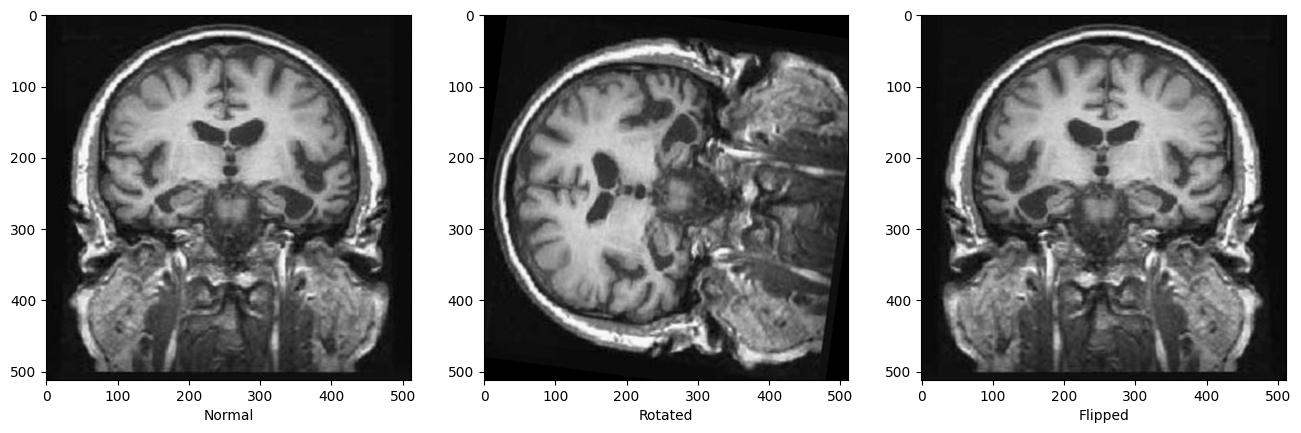

In [14]:
# visualising transformations

fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(images[0])
plt.xlabel('Normal')
fig.add_subplot(1, 3, 2)
plt.imshow(rotated[0])
plt.xlabel('Rotated')
fig.add_subplot(1, 3, 3)
plt.imshow(flipped[0])
plt.xlabel('Flipped')
plt.show()
fig.savefig(path + '/augmentation.png')

In [11]:
df_aug

,file_name,label
0,rotated_0000.jpg,pituitary_tumor
1,flipped_0000.jpg,pituitary_tumor
2,rotated_0001.jpg,pituitary_tumor
3,flipped_0001.jpg,pituitary_tumor
4,rotated_0002.jpg,meningioma_tumor
...,...,...
4195,flipped_2097.jpg,glioma_tumor
4196,rotated_2098.jpg,glioma_tumor
4197,flipped_2098.jpg,glioma_tumor
4198,rotated_2099.jpg,glioma_tumor


# Extracting Features

In [12]:
# turning classes into numbers so that it can be used as a binary classifier
classes = {'meningioma_tumor': 0, 'no_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3}


# creating function to preprocess images and then extract features and save them to the correct place for later use

def feature_extraction(data, aug, save_dir, test):
    hog_features = []
    wavelet_features_2 = []
    wavelet_features_3 = []
    labels = []
    if aug == True:
        image_dir = 'image_aug'
    elif test == True:
        image_dir = 'test/image'

    else:
        image_dir = 'image'

    for row in tqdm(data.iterrows()):
        image_name = row[1][0]
        label = row[1][1]
        # opening image
        img = cv2.imread(path + f'./dataset/{image_dir}/{image_name}')
        
        # grayscaling image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # normalising images between 0 and 1
        img = img/255

        # resizing images to 256 pixels square

        img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)


        # creating features and appending to arrays
        features, hog_image = calculate_hog_features(img)
        hog_features.append(features)

        features = wavelet_feature(img, 2)
        LL, (LH, HL, HH) = features
        wavelet_features_2.append(LL.flatten())

        features = wavelet_feature(img, 3)
        LL, (LH, HL, HH) = features
        wavelet_features_3.append(LL.flatten())

        # saving labels
        labels.append(classes[label])

    #saving features
    np.save(f'{save_dir}/hog.npy', hog_features)
    np.save(f'{save_dir}/wavelet_2x.npy', wavelet_features_2)
    np.save(f'{save_dir}/wavelet_3x.npy', wavelet_features_3)
    np.save(f'{save_dir}/labels.npy', labels)

In [13]:
# running feature extraction on all dataframes

feature_extraction(df_train, aug=False, save_dir=path + '/Task B/features/train', test=False)
feature_extraction(df_validate, aug=False, save_dir=path + '/Task B/features/validate', test=False)
feature_extraction(df_aug, aug=True, save_dir=path + '/Task B/features/train_aug', test=False)
feature_extraction(df_test, False, path + '/Task B/features/test', test=True)

4200it [01:21, 51.51it/s]


In [34]:
# creating function for classification so different parameters can be selected for evaluation of different models

def classifier(features_selected, augmented, classifier):
    # loading features

    x_train = []
    x_validate = []
    x_test = []
    for feature_type in features_selected:
        # loading features
        if augmented == False:
            x_train.append(np.load(path + f'/Task B/features/train/{feature_type}.npy'))
            x_test.append(np.load(path + f'/Task B/features/test/{feature_type}.npy'))
            x_validate.append(np.load(path + f'/Task B/features/validate/{feature_type}.npy'))

            y_train = np.load(path + f'/Task B/features/train/labels.npy')
            y_test = np.load(path + f'/Task B/features/test/labels.npy')
            y_validate = np.load(path + f'/Task B/features/validate/labels.npy')
        else:
            y_train = []
            temp = []
            temp.append(np.load(path + f'/Task B/features/train/{feature_type}.npy'))
            temp.append(np.load(path + f'/Task B/features/train_aug/{feature_type}.npy'))
            temp = tuple(temp)
            temp = np.concatenate(temp, axis=0)
            x_train.append(temp)

            x_test.append(np.load(path + f'/Task B/features/test/{feature_type}.npy'))
            x_validate.append(np.load(path + f'/Task B/features/validate/{feature_type}.npy'))

            y_train.append(np.load(path + f'/Task B/features/train/labels.npy'))
            y_train.append(np.load(path + f'/Task B/features/train_aug/labels.npy'))
            y_train = tuple(y_train)
            y_train = np.concatenate(y_train, axis=0)
            y_test = np.load(path + f'/Task B/features/test/labels.npy')
            y_validate = np.load(path + f'/Task B/features/validate/labels.npy')

    x_train = tuple(x_train)
    x_test = tuple(x_test)
    x_validate = tuple(x_validate)
    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    x_validate = np.concatenate(x_validate, axis=1)

    # creating pipelines for different classifiers

    # standard scalar and PCA is used for all classifiers
    scalar = StandardScaler()
    pca = PCA()

    if classifier == 'svm':
        # svm classifier uses sklearn svm and hyperparameters are selected using grid search
        clf = svm.SVC()
        pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("svc", clf)])

        parameters = {
            'svc__kernel':['rbf'], 
            'svc__C':[0.1, 1, 10], 
            'svc__gamma':[0.01, 0.001, 0.0001], 
            'pca__n_components': [0.9, 0.95, 0.99, 50, 100]
        }

        

    elif classifier == 'random forest':
        # random forest classifier uses sklearn svm and hyperparameters are selected using grid search
        clf = RandomForestClassifier()
        pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("clf", clf)])

        parameters = {
            'clf__n_estimators': [10, 50, 100, 200],
            'clf__bootstrap': [True],
            'pca__n_components': [50, 100, 150]
        }

    elif classifier == 'knn':
        clf = KNeighborsClassifier()
        pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("clf", clf)])

        parameters = {
            'clf__n_neighbors': [1, 2, 3],
            'pca__n_components': [0.9, 0.95, 0.99, 50, 100]
        }
    # grid search on the parameters
    grid = HalvingGridSearchCV(pipe, parameters, refit=True,  verbose = 1)
    grid.fit(x_train, y_train)

    return grid, x_test, y_test, x_validate, y_validate

# Training and Evaluating Classifiers and Features

## This is a a test run to make sure the above function works so that all the models can be run at the same time

In [ ]:
# creating function to test a variety of different combinations and select the best features
features = ['hog']
grid, x_test, y_test, x_val, y_val = classifier(features, augmented=True, classifier='svm')

In [32]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'pca__n_components': 100, 'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=100)),
                ('svc', SVC(C=10, gamma=0.001))])


C:\Users\Gebruiker\.conda\envs\AMLS-assigment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


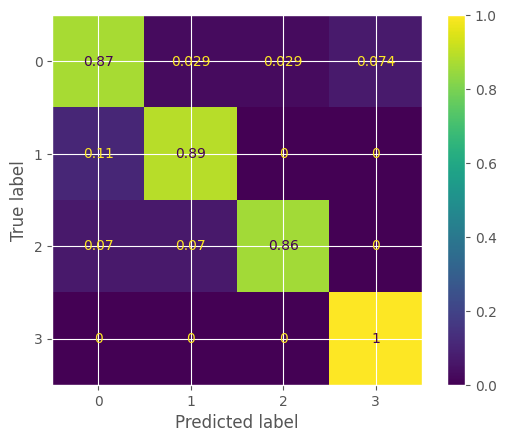

accuracy:  0.905
{'meningioma_tumor': {'precision': 0.8939393939393939, 'recall': 0.8676470588235294, 'f1-score': 0.8805970149253731, 'support': 68}, 'no_tumor': {'precision': 0.868421052631579, 'recall': 0.8918918918918919, 'f1-score': 0.88, 'support': 37}, 'glioma_tumor': {'precision': 0.9487179487179487, 'recall': 0.8604651162790697, 'f1-score': 0.9024390243902439, 'support': 43}, 'pituitary_tumor': {'precision': 0.9122807017543859, 'recall': 1.0, 'f1-score': 0.9541284403669724, 'support': 52}, 'accuracy': 0.905, 'macro avg': {'precision': 0.9058397742608268, 'recall': 0.9050010167486228, 'f1-score': 0.9042911199206474, 'support': 200}, 'weighted avg': {'precision': 0.9057646301067354, 'recall': 0.905, 'f1-score': 0.9043007698139423, 'support': 200}}


In [34]:
from sklearn.metrics import f1_score
plot_confusion_matrix(grid, x_test, y_test, normalize='true')
plt.show()

pred = grid.predict(x_test)
accuracy = accuracy_score(y_test, pred)
# f1 = f1_score(y_test, pred)
print('accuracy: ', accuracy)
# print('f1 score: ', f1)
# print classification report
report = classification_report(y_test, pred, output_dict=True, target_names=['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor'])
print(report)

## Creating the dataframe to house the results

In [15]:
df_results = pd.DataFrame(columns=['Classifier', 'Augmented', 'Features', 'PCA', 'Classifier_Metrics', 'Val accuracy', 'Test accuracy','Meningioma', 'No tumor', 'Glioma', 'Pituitary'])

In [16]:
df_results

,Classifier,Augmented,Features,PCA,Classifier_Metrics,Val accuracy,Test accuracy,Meningioma,No tumor,Glioma,Pituitary


# Function to train all possible combinations

In [ ]:
import itertools
import pickle

# defining parameters which the algorithm can choose from
augment = [False, True]
classification = ['svm', 'random forest', 'knn']
features = ['hog', 'wavelet_3x', 'wavelet_2x']

# this small section creates all possible combinations for the features as we can combine them in many ways
all_combinations = []
for r in range(len(features) + 1):
    combinations_object = itertools.combinations(features, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

del all_combinations[0]

max_accuracy = 0

# looping through all the different parameters to train seperate models and append them to the dataframe
for aug in augment:
    for classif in classification:
        for feature in all_combinations:
            grid, x_test, y_test, x_val, y_val = classifier(feature, aug, classif)
            pred = grid.predict(x_val)
            params = str(grid.best_estimator_)
            val_report = classification_report(y_val, pred, output_dict=True, target_names=['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor'])
            pred2 = grid.predict(x_test)
            test_report = classification_report(y_test, pred2, output_dict=True, target_names=['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'pituitary_tumor'])
            new_row = {
                'Classifier': classif,
                'Augmented': str(aug),
                'Features': str(feature),
                'PCA': str(grid.best_estimator_[1]),
                'Classifier_Metrics': str(grid.best_estimator_[2]),
                'Val accuracy': val_report['accuracy'],
                'Test accuracy': test_report['accuracy'], 
                'Meningioma': test_report['meningioma_tumor']['f1-score'], 
                'No tumor': test_report['no_tumor']['f1-score'],
                'Glioma': test_report['glioma_tumor']['f1-score'],
                'Pituitary': test_report['pituitary_tumor']['f1-score']
                }
            df_results = df_results.append(new_row, ignore_index=True)
            df_results.to_csv(path + '/Task B/results3.csv', index=False)
            if max_accuracy < test_report['accuracy']:
                max_accuracy = test_report['accuracy']
                pickle.dump(grid, open(path + '/Task B/best_model2.sav', 'wb'))
            


# Loading saved data

In [7]:
df_results = pd.read_csv(path + '/Task B/results3.csv')

In [8]:
# finding top 5 classifiers
df_results_top_5 = df_results.nlargest(5, ['Test accuracy']).sort_values('Test accuracy', ascending=False)
df_results_top_5

,Classifier,Augmented,Features,PCA,Classifier_Metrics,Val accuracy,Test accuracy,Meningioma,No tumor,Glioma,Pituitary
21,svm,True,"('hog',)",PCA(n_components=0.9),"SVC(C=10, gamma=0.001)",0.911111,0.935,0.933333,0.918919,0.915663,0.962963
4,svm,False,"('hog', 'wavelet_2x')",PCA(n_components=0.95),"SVC(C=10, gamma=0.0001)",0.915556,0.915,0.892308,0.921053,0.873563,0.971963
17,knn,False,"('hog', 'wavelet_3x')",PCA(n_components=0.9),KNeighborsClassifier(n_neighbors=1),0.935556,0.915,0.897059,0.931507,0.880952,0.953271
6,svm,False,"('hog', 'wavelet_3x', 'wavelet_2x')",PCA(n_components=0.95),"SVC(C=10, gamma=0.0001)",0.922222,0.910,0.885496,0.909091,0.883721,0.962264
24,svm,True,"('hog', 'wavelet_3x')",PCA(n_components=100),"SVC(C=10, gamma=0.001)",0.935556,0.905,0.888889,0.853333,0.894118,0.971429


In [9]:
# saving top 5 classifiers
df_results_top_5.to_csv(path + '/Task B/top-5.csv')

# Data exploration

In [7]:
df_results = pd.read_csv('./results3.csv')

In [ ]:
# creating bar chart to show the differences between augmented and non augmented data
labels = df_results[df_results['Augmented'] == False]['Features'].tolist()
no_aug = df_results[df_results['Augmented'] == False]
aug = df_results[df_results['Augmented'] == True]

x = np.arange(len(labels))*4  # the label locations
width = 1  # the width of the bars
plt.style.use('ggplot')
plt.figure(figsize=(32, 16))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_aug['Test accuracy'].to_list(), width, label='No augment')
rects2 = ax.bar(x + width/2, aug['Test accuracy'].to_list(), width, label='Augmented')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Scores Features and augmentation')
ax.set_xticks(x, labels, rotation=90)
ax.set_ylim(0.75, 1)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [8]:
# separating the data into augmented and non augmented dataframes
augmented = df_results['Augmented']

augmented_results = df_results[augmented]['Test accuracy'].describe()
non_augmented_results = df_results[~augmented]['Test accuracy'].describe()

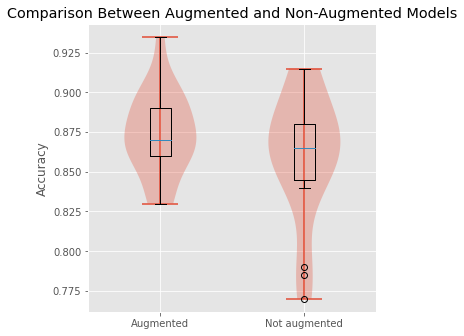

In [10]:
# creating graph to compare the augmented and non augmented results
data1 = df_results[augmented]['Test accuracy']
data2 = df_results[~augmented]['Test accuracy']
plt.style.use('ggplot')


fig = plt.figure(figsize =(4, 4))

 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
vp = ax.violinplot([data1, data2])
bp = ax.boxplot([data1, data2])
ax.set_xticks([1, 2],['Augmented', 'Not augmented'])
# ax.set_xlabel('Data augmentation used')
ax.set_ylabel('Accuracy')


plt.title('Comparison Between Augmented and Non-Augmented Models')
 
# show plot
plt.show()

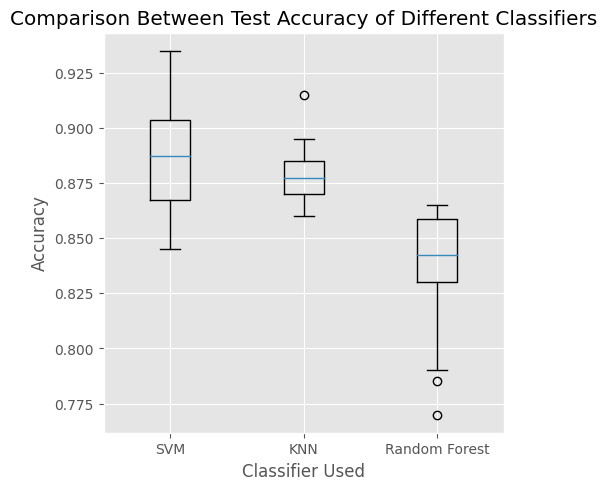

In [23]:
# creating graph to compare the different classifiers
data1 = df_results[df_results['Classifier'] == 'svm']['Test accuracy']
data2 = df_results[df_results['Classifier'] == 'knn']['Test accuracy']
data3 = df_results[df_results['Classifier'] == 'random forest']['Test accuracy']


fig = plt.figure(figsize =(4, 4))

 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot([data1, data2, data3])
ax.set_xticks([1, 2, 3],['SVM', 'KNN', 'Random Forest'])
# ax.set_xlabel('Data augmentation used')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier Used')


plt.title('Comparison Between Test Accuracy of Different Classifiers')
 
# show plot
plt.show()

# Converting table to latex format

In [6]:
# loading results
df_results = pd.read_csv(path + '/Task B/results3.csv')

In [10]:
df_results.head(5)

,Classifier,Augmented,Features,PCA,Classifier_Metrics,Val accuracy,Test accuracy,Meningioma,No tumor,Glioma,Pituitary
0,svm,False,"('hog',)",PCA(n_components=100),"SVC(C=10, gamma=0.001)",0.918889,0.895,0.865672,0.918919,0.853659,0.945455
1,svm,False,"('wavelet_3x',)",PCA(n_components=0.99),"SVC(C=10, gamma=0.001)",0.907778,0.875,0.848485,0.876712,0.827586,0.944444
2,svm,False,"('wavelet_2x',)",PCA(n_components=0.99),"SVC(C=10, gamma=0.0001)",0.876667,0.880,0.874074,0.845070,0.840909,0.943396
3,svm,False,"('hog', 'wavelet_3x')",PCA(n_components=0.99),"SVC(C=10, gamma=0.0001)",0.913333,0.880,0.833333,0.945946,0.823529,0.935780
4,svm,False,"('hog', 'wavelet_2x')",PCA(n_components=0.95),"SVC(C=10, gamma=0.0001)",0.915556,0.915,0.892308,0.921053,0.873563,0.971963


In [11]:
# changing the floats to be 4 decimal places and removing unnecessary information as the table
df_results_new = df_results.assign(PCA = lambda x: x['PCA'].str.extract('(\d+.\d+|\d+)'))
df_results_new[['Val accuracy', 'Test accuracy', 'Meningioma', 'No tumor', 'Glioma', 'Pituitary']] = df_results_new[['Val accuracy', 'Test accuracy', 'Meningioma', 'No tumor', 'Glioma', 'Pituitary']].round(decimals = 4)
df_results_new = df_results_new.assign(Classifier_Metrics = lambda x: x['Classifier_Metrics'].str.extract(r'(\(.*)'))

In [13]:
df_results_new.head(5)

,Classifier,Augmented,Features,PCA,Classifier_Metrics,Val accuracy,Test accuracy,Meningioma,No tumor,Glioma,Pituitary
0,svm,False,"('hog',)",100,"(C=10, gamma=0.001)",0.9189,0.895,0.8657,0.9189,0.8537,0.9455
1,svm,False,"('wavelet_3x',)",0.99,"(C=10, gamma=0.001)",0.9078,0.875,0.8485,0.8767,0.8276,0.9444
2,svm,False,"('wavelet_2x',)",0.99,"(C=10, gamma=0.0001)",0.8767,0.880,0.8741,0.8451,0.8409,0.9434
3,svm,False,"('hog', 'wavelet_3x')",0.99,"(C=10, gamma=0.0001)",0.9133,0.880,0.8333,0.9459,0.8235,0.9358
4,svm,False,"('hog', 'wavelet_2x')",0.95,"(C=10, gamma=0.0001)",0.9156,0.915,0.8923,0.9211,0.8736,0.9720


In [15]:
# saving the results
df_results_new.to_csv(path + '/Task B/results_final.csv', index=False)